In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Ellipse
import jupyterlab
from scipy.stats import multivariate_normal

In [2]:
cov_blue = np.vstack(([1/8,0],[0,1/4]))
mean_blue = np.array(([0,0]))
cov_red = np.vstack(([2,0],[0,1/2]))
mean_red = np.array(([1,2]))

In [7]:
N = 500

In [8]:
gaussian_blue = np.random.multivariate_normal(mean=mean_blue, cov=cov_blue, size=N)
gaussian_red = np.random.multivariate_normal(mean=mean_red, cov=cov_red, size=N)

/tmp/ipykernel_19541/3133126334.py:1: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(gaussian_red[:,0], gaussian_red[:,1], 'bo', color='grey', marker='.', markersize=10)
/tmp/ipykernel_19541/3133126334.py:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(gaussian_red[:,0], gaussian_red[:,1], 'bo', color='grey', marker='.', markersize=10)
/tmp/ipykernel_19541/3133126334.py:2: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(gaussian_blue[:,0], gaussian_blue[:,1], 'bo', color='grey', marker='.', markersize=10)
/tmp/ipykernel_19541/3133126334.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the

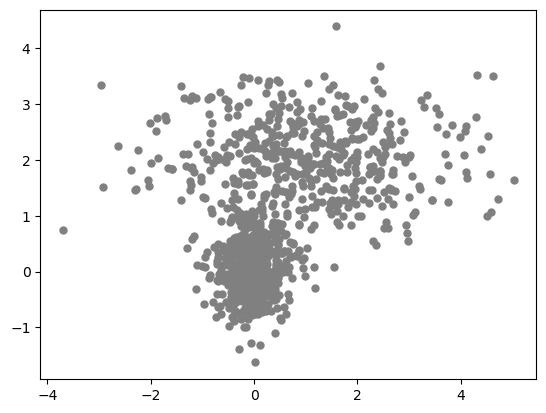

In [9]:
plt.plot(gaussian_red[:,0], gaussian_red[:,1], 'bo', color='grey', marker='.', markersize=10)
plt.plot(gaussian_blue[:,0], gaussian_blue[:,1], 'bo', color='grey', marker='.', markersize=10)

### Initializing in a 'separable' way

In [12]:
estimated_mean_0 = np.array((-2,-1))
estimated_cov_0 = np.eye(2)
estimated_mean_1 = np.array((4,4))
estimated_cov_1 = np.eye(2)

In [13]:
weighted_data = np.ones((N,5))

In [ ]:
for i in range(N):